In [1]:
import sys

import warnings
warnings.filterwarnings("ignore")

import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten, LSTM, RepeatVector, TimeDistributed
from keras.optimizers import SGD, RMSprop, Adam
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint

from keras.utils import to_categorical

from keras.models import load_model

import pymc3 as pm

import numpy as np
import pandas as pd
import time
import h5py

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import seaborn as sns

import pickle

class IO:
    def __init__(self, file_name):
        self.file_name = file_name
        
    def to_pickle(self, obj):
        with open(self.file_name, 'wb') as output:
            pickle.dump(obj, output, protocol=pickle.HIGHEST_PROTOCOL)
    
    def read_pickle(self):
        with open(self.file_name, 'rb') as input_:
            obj = pickle.load(input_)
        return obj

Using TensorFlow backend.


In [2]:
f = h5py.File('data/train.h5', 'r')
data_train = np.concatenate((f['data'].value, f['label'].value), axis=1)
f.close()
X_train = data_train[:, 0].reshape(-1, 1)
y_train = data_train[:, 1].reshape(-1, 1)
print(data_train.shape)

f = h5py.File('data/test.h5', 'r')
data_test = np.concatenate((f['data'].value, f['label'].value), axis=1)
f.close()

X_test = np.arange(-1.72, 3.51, 0.01).reshape(-1, 1)

(272, 2)


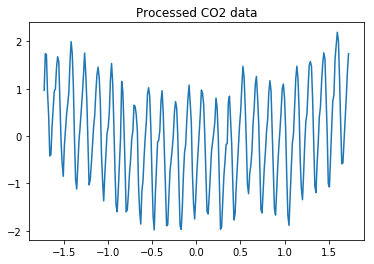

In [3]:
plt.plot(data_train[:, 0], data_train[:, 1]);
plt.title('Processed CO2 data');

In [4]:
class FFNN2:
    def __init__(self, hidden_layers=[1024, 1024, 1024, 1024, 1024], droprate=0.2, activation='relu'):
        model = Sequential()
        model.add(Dense(hidden_layers[0], activation=activation, input_shape=(1, ), kernel_initializer='lecun_uniform'))
        for d in hidden_layers[1:]:
            model.add(Dropout(droprate))
            model.add(Dense(d, activation=activation, kernel_initializer='lecun_uniform'))
        model.add(Dropout(droprate))
        model.add(Dense(1))
        self.model = model
        
    def fit(self, X_train, y_train, lr=0.0001, epochs=300000, batch_size=100, verbose=0):
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.model.compile(loss='mean_squared_error', optimizer=Adam(lr=lr))
        self.result = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
        return self
    
def predict(model, X, T=10000):
    # Reference: https://github.com/yaringal/DropoutUncertaintyExps/blob/master/bostonHousing/net/net/net.py
    standard_pred = model.predict(X)
    predict_stochastic = K.function([model.layers[0].input, K.learning_phase()], [model.layers[-1].output])
    Yt_hat = np.array([predict_stochastic([X, 1]) for _ in range(T)]).squeeze()
    return standard_pred, Yt_hat

In [ ]:
%%time

ffnn2_relu = FFNN2(activation='relu').fit(X_train, y_train, verbose=1)
ffnn2_relu.model.save('results/co2_regression_MC_relu.h5')

In [ ]:
%%time

model = load_model('results/co2_regression_MC_relu.h5')
y_pred, y_hat = predict(model, X_test)
y_mc = y_hat.mean(axis=0)
y_mc_std = y_hat.std(axis=0)
IO('results/co2_regression_MC_relu_results.pkl').to_pickle((y_pred, y_mc, y_mc_std))

In [ ]:
%%time

ffnn2_tanh = FFNN2(activation='tanh').fit(X_train, y_train, verbose=1)
ffnn2_tanh.model.save('results/co2_regression_MC_tanh.h5')

In [ ]:
%%time

model = load_model('results/co2_regression_MC_tanh.h5')
y_pred, y_hat = predict(model, X_test)
y_mc = y_hat.mean(axis=0)
y_mc_std = y_hat.std(axis=0)
IO('results/co2_regression_MC_tanh_results.pkl').to_pickle((y_pred, y_mc, y_mc_std))

In [ ]:
with pm.Model() as m:
    l = pm.HalfCauchy('l', 0.05)
    eta = pm.HalfCauchy('eta', 1)
    sigma = pm.HalfCauchy('sigma', 0.1)
        
    gp = pm.gp.Marginal(cov_func=(eta ** 2) * pm.gp.cov.ExpQuad(1, l))
    obs = gp.marginal_likelihood('obs', X=X_train, y=y_train.squeeze(), noise=sigma, is_observed=True)

In [ ]:
%%time

with m:
    step = pm.NUTS(target_accept=0.95)
    trace1 = pm.sample(5000, tune=2000, step=step, njobs=2)

IO('results/co2_regression_gp.pkl').to_pickle((m, trace1))

In [ ]:
m, trace1 = IO('results/co2_regression_gp.pkl').read_pickle()
pm.autocorrplot(trace1, max_lag=50);

In [ ]:
pm.traceplot(trace1);

In [ ]:
pm.forestplot(trace1);

In [ ]:
with m:
    y_gp = gp.conditional('y_pred', Xnew=X_test, pred_noise=True)
    gp_samples = pm.sample_ppc(trace1, vars=[y_gp], samples=10000)
ppc = gp_samples['y_pred']
y_gp_pred = ppc.mean(axis=0)
y_gp_std = ppc.std(axis=0)
IO('results/co2_regression_gp_results.pkl').to_pickle((y_gp_pred, y_gp_std))

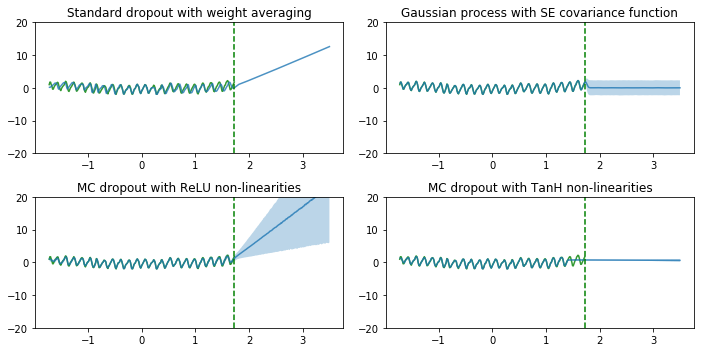

In [8]:
y_relu_pred, y_relu_mc, y_relu_mc_std = IO('results/co2_regression_MC_relu_results.pkl').read_pickle()
y_tanh_pred, y_tanh_mc, y_tanh_mc_std = IO('results/co2_regression_MC_tanh_results.pkl').read_pickle()
y_gp_pred, y_gp_std = IO('results/co2_regression_gp_results.pkl').read_pickle()

plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.plot(X_train.squeeze(), y_train.squeeze(), 'g', alpha=0.8);
plt.plot(X_test.squeeze(), y_relu_pred, alpha=0.8);
plt.axvline(X_train.squeeze()[-1], color='g',linestyle='--');
plt.title('Standard dropout with weight averaging');
plt.ylim([-20, 20]);

plt.subplot(2, 2, 2)
plt.plot(X_train.squeeze(), y_train.squeeze(), 'g', alpha=0.8);
plt.plot(X_test.squeeze(), y_gp_pred, alpha=0.8);
plt.axvline(X_train.squeeze()[-1], color='g',linestyle='--');
plt.fill_between(X_test.squeeze(), y_gp_pred-2*y_gp_std, y_gp_pred+2*y_gp_std, alpha=0.3);
plt.title('Gaussian process with SE covariance function');
plt.ylim([-20, 20]);

plt.subplot(2, 2, 3)
plt.plot(X_train.squeeze(), y_train.squeeze(), 'g', alpha=0.8);
plt.plot(X_test.squeeze(), y_relu_mc, alpha=0.8);
plt.axvline(X_train.squeeze()[-1], color='g',linestyle='--');
plt.fill_between(X_test.squeeze(), y_relu_mc-2*y_relu_mc_std, y_relu_mc+2*y_relu_mc_std, alpha=0.3);
plt.title('MC dropout with ReLU non-linearities');
plt.ylim([-20, 20]);

plt.subplot(2, 2, 4)
plt.plot(X_train.squeeze(), y_train.squeeze(), 'g', alpha=0.8);
plt.plot(X_test.squeeze(), y_tanh_mc, alpha=0.8);
plt.axvline(X_train.squeeze()[-1], color='g',linestyle='--');
plt.fill_between(X_test.squeeze(), y_tanh_mc-2*y_tanh_mc_std, y_tanh_mc+2*y_tanh_mc_std, alpha=0.3);
plt.title('MC dropout with TanH non-linearities');
plt.ylim([-20, 20]);

plt.tight_layout();